In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from time import time

from multi_arm import Arm, k_arm_bandit, epsilon_greedy

#### Set-up True Parameters

In [2]:
ctrs = np.random.normal(0.2, 0.05, 20)
baseline = np.mean(ctrs)
true_winner_idx = np.argmax(ctrs)
print("true_winner_idx:", true_winner_idx)

true_winner_idx: 19


#### Sanity Check

In [3]:
epsilon = 0.2
alpha = 0.05
winner_idx, est_p, wins, traffic, history = epsilon_greedy(ctrs, epsilon)

conversion = 100 * sum(wins) / sum(traffic)
print("good traffic: %i / %i = %.2f%%, baseline %.2f%%"%(sum(wins), 
                                                         sum(traffic), 
                                                         conversion,
                                                         baseline))

Winning arm 17 beats second arm at iteration 130
good traffic: 30 / 150 = 20.00%, baseline 0.21%


In [4]:
winner_idx, est_ps, wins, traffic, history = k_arm_bandit(ctrs)

conversion = 100 * sum(wins) / sum(traffic)
print("good traffic: %i / %i = %.2f%%, baseline %.2f%%"%(sum(wins), 
                                                         sum(traffic), 
                                                         conversion,
                                                         baseline))

Winning arm 19 beats second arm at iteration 11272
good traffic: 3254 / 11272 = 28.87%, baseline 0.21%


#### Simulation

In [20]:
cols = ["n_arms", "true_winner_idx", "winner_idx", "true_winner_ctr", "winner_ctr", "traffic", "wins", "baseline"]

ns_arms = list(range(10, 201, 10))
n_trial = 4

In [21]:
start = time()

df_ep = pd.DataFrame(columns=cols)
df_ka = df_ep.copy()

for i, n_arms in enumerate(ns_arms):
    for j in range(n_trial):
        ctrs = np.random.normal(0.2, 0.05, n_arms)
        true_winner_idx = np.argmax(ctrs)
        winner_idx, est_p, wins, traffic, history = epsilon_greedy(ctrs=ctrs, epsilon=0.2, burn_in=1000, silent=True)
        vals = [n_arms, true_winner_idx, winner_idx, ctrs[true_winner_idx], ctrs[winner_idx], sum(traffic), sum(wins), np.mean(ctrs)]
        df_ep = df_ep.append({key : val for key, val in zip(cols, vals)}, ignore_index=True)
        
        winner_idx, est_ps, wins, traffic, history = k_arm_bandit(ctrs=ctrs, burn_in=1000, silent=True)
        vals = [n_arms, true_winner_idx, winner_idx, ctrs[true_winner_idx], ctrs[winner_idx], sum(traffic), sum(wins), np.mean(ctrs)]
        df_ka = df_ka.append({key : val for key, val in zip(cols, vals)}, ignore_index=True)
        
        print("%i arm, trial %i / %i, overall progress: %.2f%%"
              %(n_arms, j, n_trial, 100 * (i * n_trial + j) / (len(ns_arms) * n_trial)) , end='\r')
        
        df_ep["conversion"] = df_ep.wins / df_ep.traffic
        df_ka["conversion"] = df_ka.wins / df_ka.traffic

        df_ep.to_csv("outputs/df_ep_%i-%i_arms.csv"%(ns_arms[0], ns_arms[-1]), index=None)
        df_ka.to_csv("outputs/df_ka_%i-%i_arms.csv"%(ns_arms[0], ns_arms[-1]), index=None)

end = time()
print("\ntime elapsed: %.2fs"%(end - start))

200 arm, trial 3 / 4, overall progress: 98.75%
time elapsed: 3024.23s


In [22]:
df_ep.head()

,n_arms,true_winner_idx,winner_idx,true_winner_ctr,winner_ctr,traffic,wins,baseline,conversion
0,10.0,8.0,8.0,0.301960,0.301960,10802.0,2544.0,0.203780,0.235512
1,10.0,9.0,9.0,0.267899,0.267899,1031.0,245.0,0.181475,0.237633
2,10.0,0.0,0.0,0.310220,0.310220,1137.0,287.0,0.195471,0.252419
3,10.0,4.0,4.0,0.277124,0.277124,12313.0,3068.0,0.175934,0.249168
4,20.0,0.0,0.0,0.269217,0.269217,100020.0,25243.0,0.196047,0.252380


#### Analyze Results

In [23]:
df_ep = pd.read_csv("outputs/df_ep_%i-%i_arms.csv"%(ns_arms[0], ns_arms[-1]))
df_ka = pd.read_csv("outputs/df_ka_%i-%i_arms.csv"%(ns_arms[0], ns_arms[-1]))
df_ep.head()

,n_arms,true_winner_idx,winner_idx,true_winner_ctr,winner_ctr,traffic,wins,baseline,conversion
0,10.0,8.0,8.0,0.301960,0.301960,10802.0,2544.0,0.203780,0.235512
1,10.0,9.0,9.0,0.267899,0.267899,1031.0,245.0,0.181475,0.237633
2,10.0,0.0,0.0,0.310220,0.310220,1137.0,287.0,0.195471,0.252419
3,10.0,4.0,4.0,0.277124,0.277124,12313.0,3068.0,0.175934,0.249168
4,20.0,0.0,0.0,0.269217,0.269217,100020.0,25243.0,0.196047,0.252380


In [24]:
import pandasql

q = """
SELECT 
    n_arms
    ,AVG(wins) AS wins
    ,AVG(traffic) AS traffic
    ,AVG(conversion) AS conversion
    ,AVG(baseline) AS baseline
    ,SUM(CASE WHEN true_winner_idx = winner_idx THEN 1 ELSE 0 END) AS success
FROM %s
GROUP BY n_arms
"""

In [25]:
df_ep_agg = pandasql.sqldf(q.lower()%"df_ep", locals())
df_ep_agg["success_prob"] = df_ep_agg["success"] / n_trial
df_ep_agg.head()

,n_arms,wins,traffic,conversion,baseline,success,success_prob
0,10.0,1536.00,6320.75,0.243683,0.189165,4,1.00
1,20.0,13750.50,54392.75,0.253120,0.209111,3,0.75
2,30.0,1727.75,7121.00,0.234093,0.199341,3,0.75
3,40.0,13762.25,51012.00,0.250123,0.199385,1,0.25
4,50.0,8192.25,31427.75,0.259259,0.200829,2,0.50


In [26]:
df_ka_agg = pandasql.sqldf(q.lower()%"df_ka", locals())
df_ka_agg["success_prob"] = df_ka_agg["success"] / n_trial
df_ka_agg.head()

,n_arms,wins,traffic,conversion,baseline,success,success_prob
0,10.0,1369.25,5321.75,0.261534,0.189165,4,1.00
1,20.0,15151.50,57745.50,0.264425,0.209111,3,0.75
2,30.0,7285.75,27273.50,0.255836,0.199341,3,0.75
3,40.0,10632.50,37944.25,0.258395,0.199385,4,1.00
4,50.0,5462.25,21137.25,0.257395,0.200829,3,0.75


In [27]:
df_ep_std = df_ep[["n_arms", "traffic", "wins", "conversion"]].groupby('n_arms').std()
df_ka_std = df_ka[["n_arms", "traffic", "wins", "conversion"]].groupby('n_arms').std()

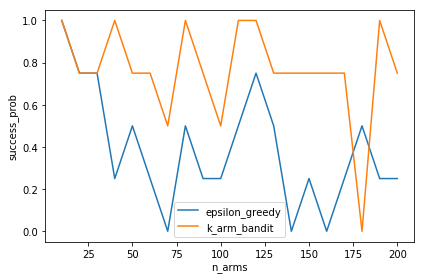

In [28]:
plt.plot(df_ep_agg.n_arms, df_ep_agg.success_prob)
plt.plot(df_ka_agg.n_arms, df_ka_agg.success_prob)

plt.xlabel("n_arms")
plt.ylabel("success_prob")

plt.legend(["epsilon_greedy", "k_arm_bandit"])

plt.tight_layout()

plt.savefig('outputs/compare_ep_ka_%i-%i_arms_success_prob.png'%(ns_arms[0], ns_arms[-1]))

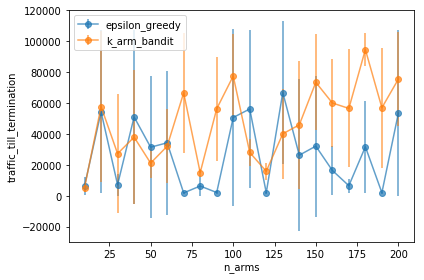

In [29]:
# no error bar
# plt.plot(df_ep_agg.n_arms, df_ep_agg.traffic)
# plt.plot(df_ka_agg.n_arms, df_ka_agg.traffic)

# add error bar
plt.errorbar(df_ep_agg.n_arms, df_ep_agg.traffic, df_ep_std.traffic, linestyle='-', marker='o', alpha=0.7)
plt.errorbar(df_ka_agg.n_arms, df_ka_agg.traffic, df_ka_std.traffic, linestyle='-', marker='o', alpha=0.7)

plt.xlabel("n_arms")
plt.ylabel("traffic_till_termination")

plt.legend(["epsilon_greedy", "k_arm_bandit"])

plt.tight_layout()

plt.savefig('outputs/compare_ep_ka_%i-%i_arms_traffic.png'%(ns_arms[0], ns_arms[-1]))

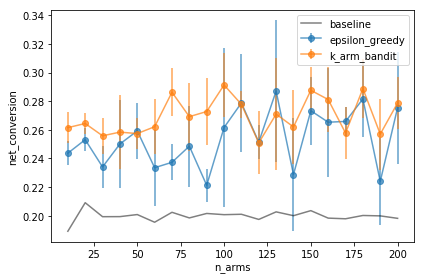

In [30]:
# no error bar
# plt.plot(df_ep_agg.n_arms, df_ep_agg.conversion)
# plt.plot(df_ka_agg.n_arms, df_ka_agg.conversion)

# add error bar
plt.plot(df_ka_agg.n_arms, df_ep_agg.baseline, color='black', alpha=0.5)
plt.errorbar(df_ep_agg.n_arms, df_ep_agg.conversion, df_ep_std.conversion, linestyle='-', marker='o', alpha=0.7)
plt.errorbar(df_ka_agg.n_arms, df_ka_agg.conversion, df_ka_std.conversion, linestyle='-', marker='o', alpha=0.7)

plt.xlabel("n_arms")
plt.ylabel("net_conversion")

plt.legend(["baseline", "epsilon_greedy", "k_arm_bandit"])

plt.tight_layout()

plt.savefig('outputs/compare_ep_ka_%i-%i_arms_conversion.png'%(ns_arms[0], ns_arms[-1]))

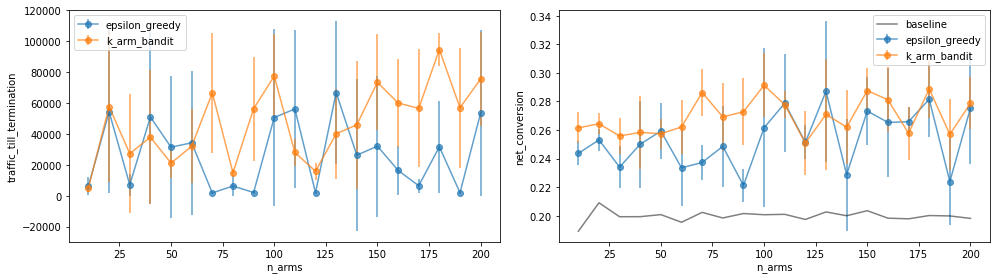

In [31]:
plt.figure(figsize=(14, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.errorbar(df_ep_agg.n_arms, df_ep_agg.traffic, df_ep_std.traffic, linestyle='-', marker='o', alpha=0.7)
ax1.errorbar(df_ka_agg.n_arms, df_ka_agg.traffic, df_ka_std.traffic, linestyle='-', marker='o', alpha=0.7)

ax1.set_xlabel("n_arms")
ax1.set_ylabel("traffic_till_termination")
ax1.legend(["epsilon_greedy", "k_arm_bandit"])

ax2 = plt.subplot(1, 2, 2)
ax2.plot(df_ka_agg.n_arms, df_ep_agg.baseline, color='black', alpha=0.5)
ax2.errorbar(df_ep_agg.n_arms, df_ep_agg.conversion, df_ep_std.conversion, linestyle='-', marker='o', alpha=0.7)
ax2.errorbar(df_ka_agg.n_arms, df_ka_agg.conversion, df_ka_std.conversion, linestyle='-', marker='o', alpha=0.7)

ax2.set_xlabel("n_arms")
ax2.set_ylabel("net_conversion")
ax2.legend(["baseline", "epsilon_greedy", "k_arm_bandit"])

plt.tight_layout()

plt.savefig('outputs/compare_ep_ka_%i-%i_arms_combined.png'%(ns_arms[0], ns_arms[-1]))